In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2
import os, sys, glob
import random
import tqdm
import gzip
import json
import numpy as np
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist, squareform
import pandas as pd
pd.set_option("display.max_columns", None)

from datetime import datetime
from dateutil import parser

import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec

import watermark
%load_ext watermark
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.8.10
IPython version      : 8.6.0

Compiler    : GCC 9.4.0
OS          : Linux
Release     : 5.15.0-52-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 48
Architecture: 64bit

Git hash: ba2bd370ac7999129b986fffb23b26225ad49493

numpy     : 1.23.4
watermark : 2.3.1
sys       : 3.8.10 (default, Jun 22 2022, 20:18:18) 
[GCC 9.4.0]
json      : 2.0.9
scipy     : 1.9.3
pandas    : 1.5.1
tqdm      : 4.64.1
dateutil  : 2.8.2
matplotlib: 3.1.2



### TWITTER TRENDING TOPIC ANALYSIS

In [2]:
trendingCities = dict()

for fname in glob.glob('../dataset/trends/*.jsons.gz'):
    print(fname)
    cityName = fname.split('/')[-1].split('_')[0]
    if cityName not in trendingCities:
        trendingCities[cityName] = list()

    with gzip.open(fname, 'rt') as fl:
        for line in fl:
            temp = json.loads(line)
            trendingCities[cityName].append(temp)

print(sorted(trendingCities.keys()))

../dataset/trends/Eskişehir_2022-09.jsons.gz
../dataset/trends/Antalya_2022-08.jsons.gz
../dataset/trends/Antalya_2022-07.jsons.gz
../dataset/trends/Diyarbakır_2022-09.jsons.gz
../dataset/trends/Ankara_2022-09.jsons.gz
../dataset/trends/Istanbul_2022-08.jsons.gz
../dataset/trends/Istanbul_2022-07.jsons.gz
../dataset/trends/Bursa_2022-08.jsons.gz
../dataset/trends/Bursa_2022-07.jsons.gz
../dataset/trends/Kayseri_2022-08.jsons.gz
../dataset/trends/Izmir_2022-08.jsons.gz
../dataset/trends/Kayseri_2022-07.jsons.gz
../dataset/trends/Izmir_2022-07.jsons.gz
../dataset/trends/Turkey_2022-08.jsons.gz
../dataset/trends/Turkey_2022-07.jsons.gz
../dataset/trends/Bursa_2022-09.jsons.gz
../dataset/trends/Istanbul_2022-09.jsons.gz
../dataset/trends/Antalya_2022-09.jsons.gz
../dataset/trends/Eskişehir_2022-08.jsons.gz
../dataset/trends/Eskişehir_2022-07.jsons.gz
../dataset/trends/Diyarbakır_2022-08.jsons.gz
../dataset/trends/Diyarbakır_2022-07.jsons.gz
../dataset/trends/Ankara_2022-08.jsons.gz
../data

In [3]:
# Compute trend similarities

# Dates if we want to filter
fromDate, toDate = parser.parse('2020-01-01'), parser.parse('2025-01-01') 

topN = 10
uniqueTrendsByCities, uniqueTrendsByCitiesD = dict(), dict()
uniquePhrasesByCities, uniquePhrasesByCitiesD = dict(), dict()
uniqueHashtagsByCities, uniqueHashtagsByCitiesD = dict(), dict()
for city in trendingCities:
    uniqueTrendsByCities[city] = set()
    uniquePhrasesByCities[city] = set()
    uniqueHashtagsByCities[city] = set()
    uniqueTrendsByCitiesD[city] = dict()
    uniquePhrasesByCitiesD[city] = dict()
    uniqueHashtagsByCitiesD[city] = dict()
    for trend in trendingCities[city]:
        tdate = parser.parse(trend['created_at'].replace('Z',''))
        dayStr = datetime.strftime(tdate, '%Y-%m-%d')
        if dayStr not in uniqueHashtagsByCitiesD[city]:
            uniqueTrendsByCitiesD[city][dayStr] = set()
            uniquePhrasesByCitiesD[city][dayStr] = set()
            uniqueHashtagsByCitiesD[city][dayStr] = set()
        if fromDate < tdate < toDate:
            uniqueTrendsByCities[city] |= set([t['name'].lower() for t in trend['trends']][:topN])
            uniquePhrasesByCities[city] |= set([t['name'].lower() for t in trend['trends'] if '#' not in t['name']][:topN])
            uniqueHashtagsByCities[city] |= set([t['name'].lower() for t in trend['trends'] if '#' in t['name']][:topN])
            uniqueTrendsByCitiesD[city][dayStr] |= set([t['name'].lower() for t in trend['trends']][:topN])
            uniquePhrasesByCitiesD[city][dayStr] |= set([t['name'].lower() for t in trend['trends'] if '#' not in t['name']][:topN])
            uniqueHashtagsByCitiesD[city][dayStr] |= set([t['name'].lower() for t in trend['trends'] if '#' in t['name']][:topN])

for city in uniqueTrendsByCities:
    print("{}: {} unique trends, {} unique hashtags, {} unique phrases".format(
        city,
        len(uniqueTrendsByCities[city]),
        len(uniqueHashtagsByCities[city]),
        len(uniquePhrasesByCities[city])
    ))

Eskişehir: 4700 unique trends, 2724 unique hashtags, 4286 unique phrases
Antalya: 4722 unique trends, 2854 unique hashtags, 4259 unique phrases
Diyarbakır: 4832 unique trends, 2737 unique hashtags, 4281 unique phrases
Ankara: 4801 unique trends, 2840 unique hashtags, 4272 unique phrases
Istanbul: 5067 unique trends, 2850 unique hashtags, 4344 unique phrases
Bursa: 4765 unique trends, 2787 unique hashtags, 4279 unique phrases
Kayseri: 4788 unique trends, 2782 unique hashtags, 4263 unique phrases
Izmir: 4690 unique trends, 2840 unique hashtags, 4275 unique phrases
Turkey: 4731 unique trends, 2883 unique hashtags, 4278 unique phrases
Mersin: 4758 unique trends, 2837 unique hashtags, 4265 unique phrases
Gaziantep: 4740 unique trends, 2840 unique hashtags, 4259 unique phrases
Konya: 4771 unique trends, 2783 unique hashtags, 4267 unique phrases
Adana: 4717 unique trends, 2791 unique hashtags, 4261 unique phrases


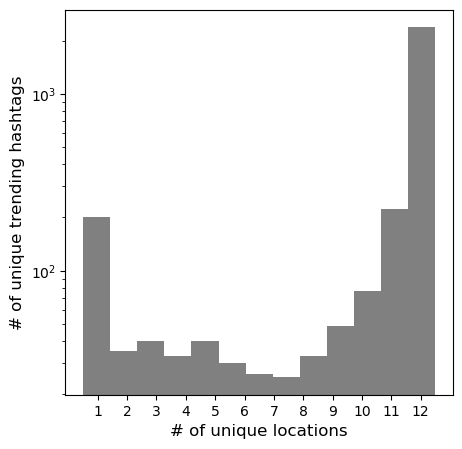

In [4]:
# Trend frequencies
trendCityCount = dict()
for c in uniqueHashtagsByCities:
    for t in uniqueHashtagsByCities[c]:
        if t not in trendCityCount:
            trendCityCount[t] = 0
        trendCityCount[t] += 1

fig = plt.figure(figsize=(5,5))
plt.hist(list(trendCityCount.values()), bins=len(uniqueHashtagsByCities), fc='0.5')
plt.xticks(np.arange(1,len(uniqueHashtagsByCities))+0.5, range(1,len(uniqueHashtagsByCities)))
plt.yscale('log')
plt.xlabel('# of unique locations', fontsize=12)
plt.ylabel('# of unique trending hashtags', fontsize=12)
plt.savefig('figures/trend_city_freq.pdf', dpi=600, transparent=True, bbox_inches='tight')

['Istanbul', 'Eskişehir', 'Antalya', 'Bursa', 'Adana', 'Ankara', 'Mersin', 'Diyarbakır', 'Kayseri', 'Konya', 'Gaziantep', 'Izmir']


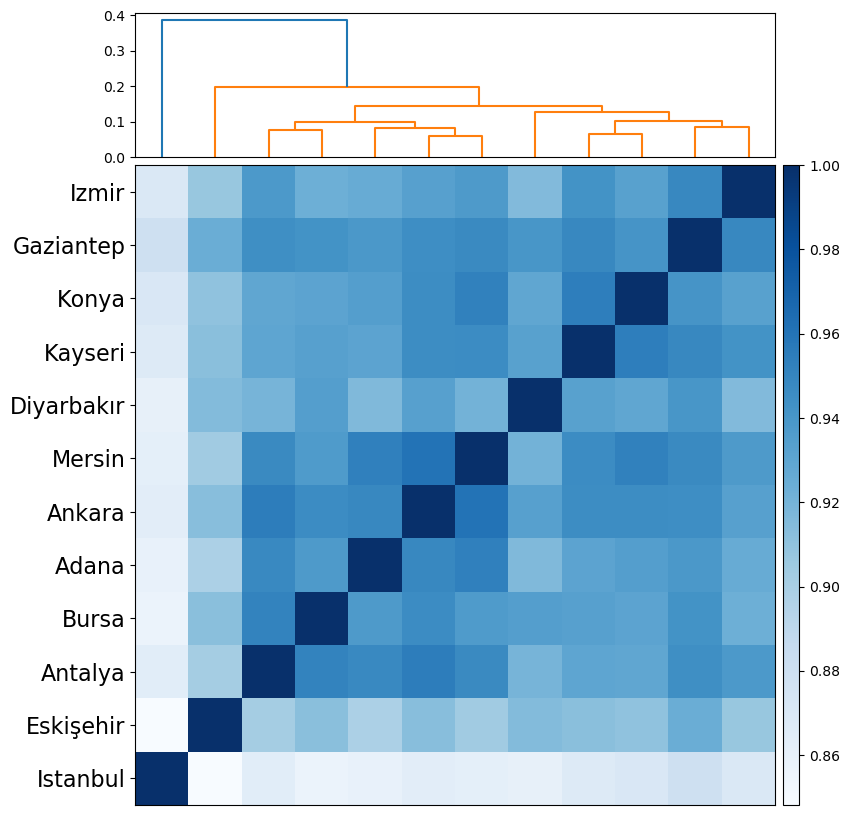

In [27]:
def plot_trend_similarity(ttopicDict):
    cityNames = sorted(ttopicDict.keys())
    simM = np.eye(len(ttopicDict))

    for i in range(len(cityNames)):
        for j in range(i+1, len(cityNames)):
            trnd1, trnd2 = ttopicDict[cityNames[i]], ttopicDict[cityNames[j]]
            simVal = len(trnd1 & trnd2) / len((trnd1 | trnd2))
            simM[i,j] = simM[j,i] = simVal
    
    labels = cityNames
    fig = plt.figure(figsize=(8,8))
    axdendro = fig.add_axes([0.1,0.82,0.8,0.18])
    Y = sch.linkage(simM, method='ward') # You can try alternative linkage methods here
    Z = sch.dendrogram(Y, orientation='top')
    axdendro.set_xticks([])
    #axdendro.set_yticks([])

    # Plot distance matrix.
    axmatrix = fig.add_axes([0.1,0.01,0.8,0.8])
    index = Z['leaves']
    simM = simM[index,:]
    simM = simM[:,index]
    im = axmatrix.matshow(simM, aspect='auto', origin='lower', cmap='Blues')
    axmatrix.set_xticks([])
    if labels != None:
        labels = [labels[i] for i in index]
        axmatrix.set_yticks(range(0,len(labels)))
        axmatrix.set_yticklabels(labels, fontsize=16)
    else:
        axmatrix.set_yticks([])

    # Plot colorbar.
    axcolor = fig.add_axes([0.91,0.01,0.02,0.8])
    plt.colorbar(im, cax=axcolor)
    plt.savefig('figures/trend_city_jaccardsim.pdf', dpi=600, transparent=True, bbox_inches='tight')
    return labels

#plot_trend_similarity(uniqueHashtagsByCities)
labels = plot_trend_similarity({k:v for k,v in uniqueHashtagsByCities.items() if k != 'Turkey'})
print(labels)


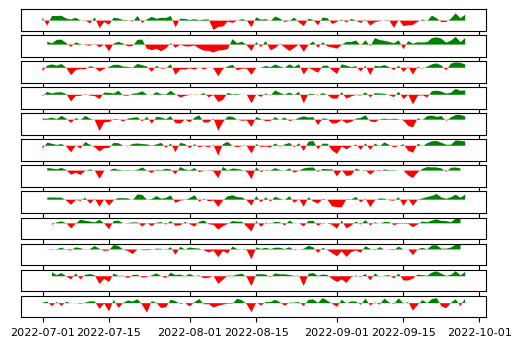

In [6]:
fig, axarr = plt.subplots(len(labels),1, sharex=True, sharey=True, figsize=(6,4))
for i,l in enumerate(labels):
    days = sorted(uniqueHashtagsByCitiesD[l].keys())[20:-1]
    #axarr[i].stem([len(uniqueHashtagsByCitiesD[l][d]) for d in days], 
    #    linefmt='grey', markerfmt='k.', basefmt=" ")
    overlap = list()
    for d in days:
        ctrnd, ttrnd = uniqueHashtagsByCitiesD[l][d], set(uniqueHashtagsByCitiesD['Turkey'].get(d,[]))
        overlap.append(len(ctrnd & ttrnd) / len(ctrnd | ttrnd))
    #axarr[i].plot(overlap, c='0.5')
    #axarr[i].axhline(np.mean(overlap), color='r', linestyle='--')
    xvals = [datetime.strptime(d, '%Y-%m-%d') for d in days]
    y1 = np.array([np.mean(overlap)]*len(days))
    y2 = np.array(overlap)
    axarr[i].fill_between(xvals, y1, y2, where=(y2 >= y1), interpolate=True, facecolor='green')
    axarr[i].fill_between(xvals, y1, y2, where=(y2 <= y1), interpolate=True, facecolor='red')
    axarr[i].set_yticks([])
    axarr[i].tick_params(labelsize=8)
plt.savefig('figures/trend_city-turkey_jaccard.pdf', dpi=600, transparent=True, bbox_inches='tight')

#### Trend lifetimes and repetitions

In [15]:
# Repetitive trends
def calculate_trend_sessions(trends, topN=10):
    tsess = dict() # {"trendX": [(start1, end1), (start2, end2), ...]}

    trendT = dict()
    for tt in trends:
        for t in tt['trends'][:10]:
            tname = t['name'].lower()
            if not tname.startswith('#'):
                continue

            if tname not in trendT:
                trendT[tname] = list()
            trendT[tname].append(parser.parse(tt['as_of']).timestamp())
        
    sessionLen = 30*60
    for tt in trendT:
        tstamps = sorted(trendT[tt])
        sidx = [[0,None]]
        for t in range(1, len(tstamps)):
            if (tstamps[t] - tstamps[t-1]) > sessionLen:
                sidx[-1][1] = t-1
                sidx.append([t,None])
        sidx[-1][1] = len(tstamps)-1
        #print(tt, [(tstamps[s[0]], tstamps[s[1]]) for s in sidx])
        tsess[tt] = [(tstamps[s[0]], tstamps[s[1]]) for s in sidx]

    return tsess

trendSessions = dict()
for city in trendingCities:
    trendSessions[city] = calculate_trend_sessions(trendingCities[city])
    print(city, len(trendSessions[city]))

Eskişehir 1542
Antalya 1792
Diyarbakır 1360
Ankara 1713
Istanbul 1976
Bursa 1552
Kayseri 1608
Izmir 1858
Turkey 1897
Mersin 1759
Gaziantep 1786
Konya 1622
Adana 1693


['Eskişehir',
 'Istanbul',
 'Izmir',
 'Diyarbakır',
 'Ankara',
 'Gaziantep',
 'Antalya',
 'Mersin',
 'Adana',
 'Bursa',
 'Kayseri',
 'Konya']

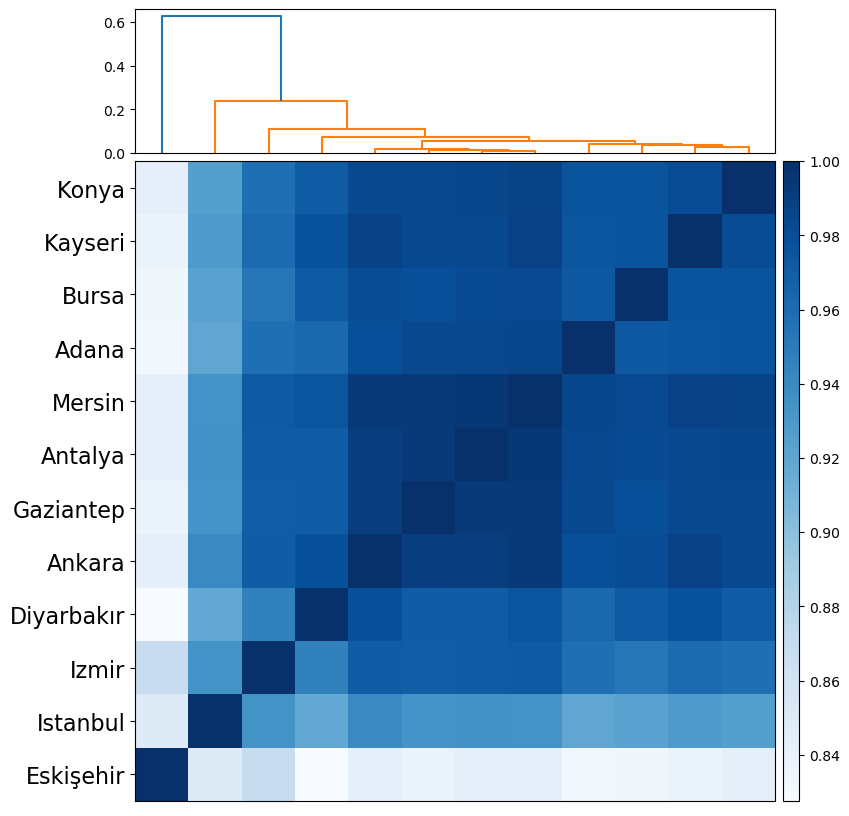

In [26]:
# Session length similarity

def plot_trend_similarity_v2(ttopicDict):

    def cosine_dic(dic1,dic2):
        numerator = 0
        dena = 0
        for key1,val1 in dic1.items():
            numerator += val1*dic2.get(key1,0.0)
            dena += val1*val1
        denb = 0
        for val2 in dic2.values():
            denb += val2*val2
        return numerator/np.sqrt(dena*denb)

    cityNames = sorted(ttopicDict.keys())
    simM = np.eye(len(ttopicDict))

    for i in range(len(cityNames)):
        for j in range(i+1, len(cityNames)):
            trnd1 = {k:sum([t[1]-t[0] for t in v]) for k,v in ttopicDict[cityNames[i]].items()}
            trnd2 = {k:sum([t[1]-t[0] for t in v]) for k,v in ttopicDict[cityNames[j]].items()}
            simVal = cosine_dic(trnd1, trnd2)
            simM[i,j] = simM[j,i] = simVal
    
    labels = cityNames
    fig = plt.figure(figsize=(8,8))
    axdendro = fig.add_axes([0.1,0.82,0.8,0.18])
    Y = sch.linkage(simM, method='ward') # You can try alternative linkage methods here
    Z = sch.dendrogram(Y, orientation='top')
    axdendro.set_xticks([])
    #axdendro.set_yticks([])

    # Plot distance matrix.
    axmatrix = fig.add_axes([0.1,0.01,0.8,0.8])
    index = Z['leaves']
    simM = simM[index,:]
    simM = simM[:,index]
    im = axmatrix.matshow(simM, aspect='auto', origin='lower', cmap='Blues')
    axmatrix.set_xticks([])
    if labels != None:
        labels = [labels[i] for i in index]
        axmatrix.set_yticks(range(0,len(labels)))
        axmatrix.set_yticklabels(labels, fontsize=16)
    else:
        axmatrix.set_yticks([])

    # Plot colorbar.
    axcolor = fig.add_axes([0.91,0.01,0.02,0.8])
    plt.colorbar(im, cax=axcolor)
    plt.savefig('figures/trend_city_cossim.pdf', dpi=600, transparent=True, bbox_inches='tight')
    return labels

labels = plot_trend_similarity_v2({k:v for k,v in trendSessions.items() if k != 'Turkey'})


Text(29.47222222222222, 0.5, 'Trend frequecy')

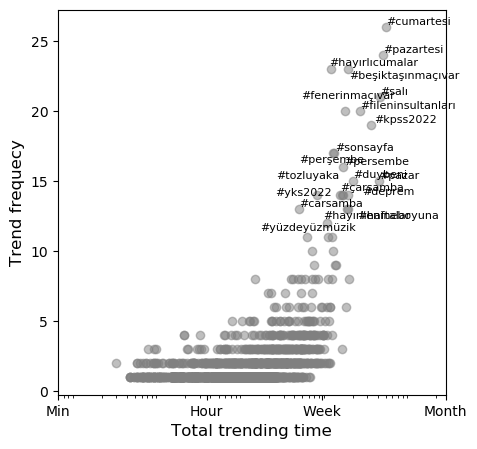

In [151]:
from adjustText import adjust_text

cityName = 'Turkey'
fig = plt.figure(figsize=(5,5))
ttime, tfreq, tnames = list(), list(), list()
usageStat = dict()
for tt in trendSessions[cityName]:
    tnames.append(tt)
    ttime.append(sum([x[1]-x[0] for x in trendSessions[cityName][tt]]))#/len(trendSessions[cityName][tt]))
    tfreq.append(len(trendSessions[cityName][tt]))
    usageStat[tt] = {
        'freq': tfreq[-1], 
        'totTime': sum([x[1]-x[0] for x in trendSessions[cityName][tt]]),
        'avgTime': ttime[-1]
    }

plt.scatter(ttime, tfreq, alpha=0.5, c='0.5')
plt.xscale('log')

texts = list()
for i in range(len(tnames)):
    if tfreq[i] > 12:# or ttime[i] > 60*60*24*30:
        #print(tnames[i], tfreq[i], ttime[i])
        texts.append(plt.text(ttime[i], tfreq[i], tnames[i], fontsize=8))
adjust_text(texts)

plt.xticks([60, 60*60, 60*60*24, 60*60*24*30], ['Min', 'Hour', 'Week', 'Month'])
plt.tick_params(labelsize=10)
plt.xlabel('Total trending time', fontsize=12)
plt.ylabel('Trend frequecy', fontsize=12)


In [178]:
dfTmp = pd.DataFrame.from_dict(usageStat, orient='index')
#dfTmp[(dfTmp['freq'] < 10) & (dfTmp['totTime'] < 60*60*5)].sort_values(by='freq', ascending=False)[:30]
dfTmp.sort_values(by='avgTime', ascending=False)[:50]

,freq,totTime,avgTime
#cumartesi,26,500505.0,500505.0
#pazartesi,24,461264.0,461264.0
#salı,21,431812.0,431812.0
#pazar,15,415719.0,415719.0
#kpss2022,19,334351.0,334351.0
#fileninsultanları,20,245749.0,245749.0
#duybeni,15,201981.0,201981.0
#15temmuz,8,183338.0,183338.0
#beşiktaşınmaçıvar,23,178333.0,178333.0
#deprem,14,177908.0,177908.0


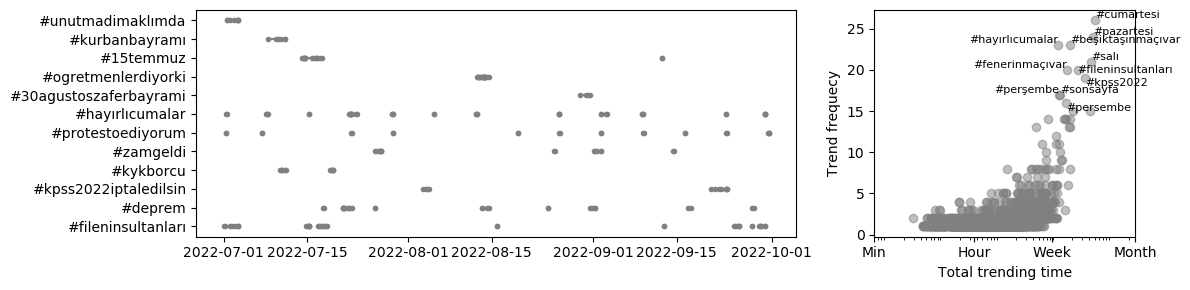

In [190]:
ttItems = ['#fileninsultanları', '#deprem', 
           '#kpss2022iptaledilsin', '#kykborcu',
           '#zamgeldi',  '#protestoediyorum', '#hayırlıcumalar',
           '#30agustoszaferbayrami', '#ogretmenlerdiyorki',
           '#15temmuz', '#kurbanbayramı', '#unutmadimaklımda'
           ]

fig = plt.figure(figsize=(12,3), tight_layout=True)
gs = gridspec.GridSpec(1, 6)

ax = fig.add_subplot(gs[0, 4:])
ax2 = fig.add_subplot(gs[0, :4])

ax.scatter(ttime, tfreq, alpha=0.5, c='0.5')
ax.set_xscale('log')

texts = list()
for i in range(len(tnames)):
    if tfreq[i] > 15:# or ttime[i] > 60*60*24*30:
        #print(tnames[i], tfreq[i], ttime[i])
        texts.append(ax.text(ttime[i], tfreq[i], tnames[i], fontsize=8))
adjust_text(texts)

ax.set_xticks([60, 60*60, 60*60*24, 60*60*24*30])
ax.set_xticklabels(['Min', 'Hour', 'Week', 'Month'])
ax.set_xlabel('Total trending time', fontsize=10)
ax.set_ylabel('Trend frequecy', fontsize=10)

for i,tt in enumerate(ttItems):
    #print(trendSessions['Turkey'][tt])
    for chnk in trendSessions['Turkey'][tt]:
        ax2.plot([datetime.fromtimestamp(c) for c in chnk], [i,i], '.-', c='0.5')
ax2.set_yticks(range(len(ttItems)))
ax2.set_yticklabels(ttItems)
plt.tight_layout()
plt.savefig('figures/trend_analysis.pdf', dpi=600, transparent=True, bbox_inches='tight')



### PARTY-MEMBERSHIP STATS

In [17]:
# https://tr.wikipedia.org/wiki/Siyasi_parti_sembolleri_listesi
PARTY_INFO = {
    "ADALET VE KALKINMA PARTİSİ": {"code":"AKP", "color":"#FF8700"},
    "CUMHURİYET HALK PARTİSİ": {"code":"CHP", "color":"#EB2229"},
    "MİLLİYETÇİ HAREKET PARTİSİ": {"code":"MHP", "color":"#57585A"},
    "İYİ PARTİ": {"code":"IYI", "color":"#30D5C8"},
    "DEMOKRASİ VE ATILIM PARTİSİ": {"code":"DEVA", "color":"#008DBC"},
    "DEMOKRAT PARTİ": {"code":"DP", "color":"m"},
    "GELECEK PARTİSİ": {"code":"GELECEK", "color":"#2db34a"},
    "SAADET PARTİSİ": {"code":"SAADET", "color":"#CF3338"},
    "HALKLARIN DEMOKRATİK PARTİSİ": {"code":"HDP", "color":"#90268F"},
}

In [3]:
latestStats = dict()
partyMembership = dict()
with open('../dataset/party_membership_stats.jsons', 'r') as fl:
    for line in fl:
        temp = json.loads(line)
        for k,v in temp.items():
            if k not in partyMembership:
                partyMembership[k] = dict()
            ldate = parser.parse(v['logDate'])
            if ldate < parser.parse("2020-01-01"):
                continue
            partyMembership[k][ldate] = v['nMember']
            latestStats[k] = v['nMember']

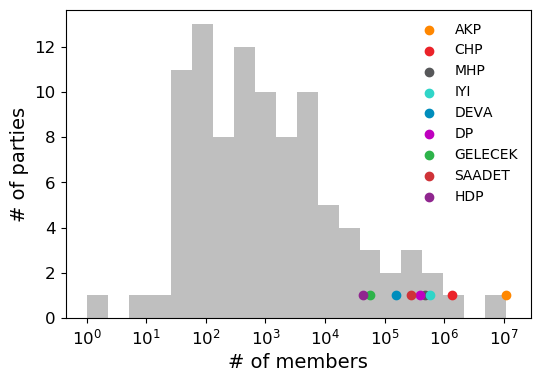

In [18]:

fig = plt.figure(figsize=(6,4))
plt.hist([np.log10(x) for x in latestStats.values() if x > 0], 
         bins=20, fc='0.5', alpha=0.5)
plt.xticks(range(8), [r'$10^{}$'.format(x) for x in range(8)])
plt.xlabel('# of members', fontsize=14)
plt.ylabel('# of parties', fontsize=14)
plt.tick_params(labelsize=12)

for p in PARTY_INFO:
    plt.scatter(np.log10(latestStats[p]), [1], zorder=9,
                c=PARTY_INFO[p]['color'], label=PARTY_INFO[p]['code'])
plt.legend(frameon=False)
plt.savefig('figures/party_member_hist.pdf', dpi=300, transparent=True, bbox_inches='tight')

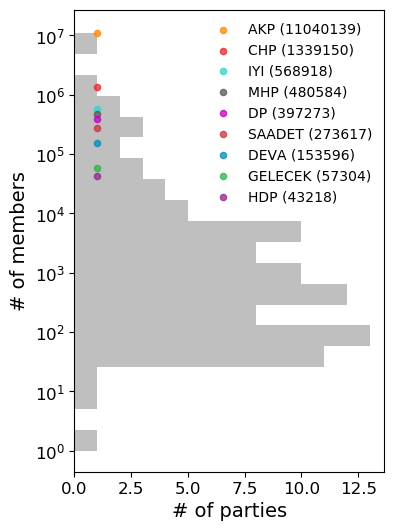

In [21]:

fig = plt.figure(figsize=(4,6))
plt.hist([np.log10(x) for x in latestStats.values() if x > 0], 
         bins=20, fc='0.5', alpha=0.5, orientation="horizontal")
plt.yticks(range(8), [r'$10^{}$'.format(x) for x in range(8)])
plt.ylabel('# of members', fontsize=14)
plt.xlabel('# of parties', fontsize=14)
plt.tick_params(labelsize=12)

for p in sorted(PARTY_INFO, key=lambda x: latestStats[x], reverse=True):
    plt.scatter([1], np.log10(latestStats[p]), zorder=9, s=20, alpha=0.75,
                c=PARTY_INFO[p]['color'], label="{} ({})".format(PARTY_INFO[p]['code'], latestStats[p]))
plt.legend(frameon=False)
plt.savefig('figures/party_member_hist-v2.pdf', dpi=300, transparent=True, bbox_inches='tight')


[Text(0, 5, '$10^5$'), Text(0, 6, '$10^6$'), Text(0, 7, '$10^7$')]

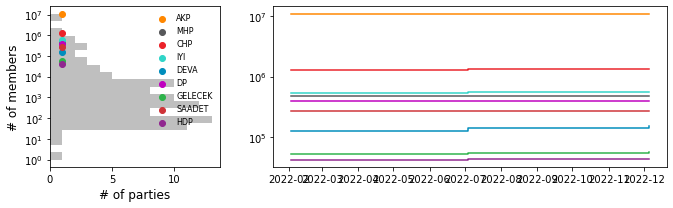

In [19]:
fig = plt.figure(figsize=(12,3), tight_layout=True)
gs = gridspec.GridSpec(1, 4)

ax = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2:])

ax.hist([np.log10(x) for x in latestStats.values() if x > 0], 
         bins=20, fc='0.5', alpha=0.5, orientation="horizontal")
ax.set_yticks(range(8))
ax.set_yticklabels([r'$10^{}$'.format(x) for x in range(8)])
ax.set_ylabel('# of members', fontsize=12)
ax.set_xlabel('# of parties', fontsize=12)
ax.tick_params(labelsize=10)

for p in PARTY_INFO:
    ax.scatter([1], np.log10(latestStats[p]), zorder=9,
                c=PARTY_INFO[p]['color'], label=PARTY_INFO[p]['code'])
    dates = sorted(partyMembership[p].keys())
    ax2.step(dates, np.log10([partyMembership[p][d] for d in dates]), 
             c=PARTY_INFO[p]['color'], where='post')
ax.legend(frameon=False, fontsize=8)
ax2.set_yticks(range(5,8))
ax2.set_yticklabels([r'$10^{}$'.format(x) for x in range(5,8)])


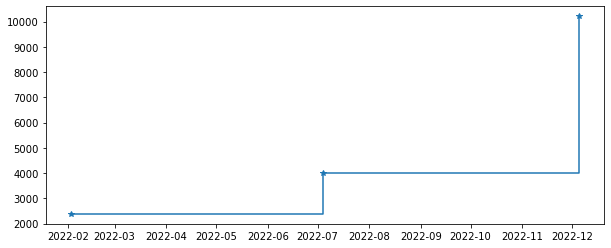

In [17]:
p = 'ZAFER PARTİSİ'
dates = sorted(partyMembership[p].keys())
fig = plt.figure(figsize=(10,4))
plt.step(dates, [partyMembership[p][d] for d in dates], '*-', where='post')

In [8]:
partyMembership.keys()

dict_keys(['ADALET BİRLİK PARTİSİ', 'ADALET PARTİSİ', 'ADALET VE KALKINMA PARTİSİ', 'ADALET VE ÖZGÜRLÜK\xa0PARTİSİ', 'ADALETİN AYDINLIĞI PARTİSİ', 'AL SANCAK PARTİSİ', 'ANADOLU BİRLİĞİ PARTİSİ', 'AS PARTİ', 'AYDINLIK DEMOKRASİ PARTİSİ', 'AYDINLIK GELECEĞİN PARTİSİ', 'AYYILDIZ PARTİSİ', 'BARIŞ VE EŞİTLİK PARTİSİ', 'BAĞIMSIZ CUMHURİYET PARTİSİ', 'BAĞIMSIZ TÜRKİYE PARTİSİ', 'BAĞIMSIZLIK PARTİSİ', 'BÜYÜK BİRLİK PARTİSİ', 'BÜYÜK TÜRKİYE PARTİSİ', 'BİRLEŞİK DEVRİMCİ PARTİ', 'CUMHURİYET HALK PARTİSİ', 'CUMHURİYET VE ADALET PARTİSİ', 'CUMHURİYET VE İSTİKLAL PARTİSİ', 'CİHAN PARTİSİ', 'DAYATMASIZ YAŞAM PARTİSİ', 'DEMOKRASİ VE ATILIM PARTİSİ', 'DEMOKRAT PARTİ', 'DEMOKRATİK BÖLGELER PARTİSİ', 'DEMOKRATİK GENÇ PARTİ', 'DEMOKRATİK SOL PARTİ', 'DEVLET PARTİSİ', 'DEVRİM HAREKETİ', 'DEVRİMCİ SOSYALİST İŞÇİ PARTİSİ', 'DEVRİMCİ İŞÇİ PARTİSİ', 'DEĞİŞİM VE DEMOKRASİ PARTİSİ', 'DOĞRU PARTİ', 'DOĞRU YOL PARTİSİ', 'DOĞUŞ PARTİSİ', 'EBEDİ NİZAM PARTİSİ', 'EMEK PARTİSİ', 'EMEKÇİ HAREKET PARTİSİ', 'EZİLENLERİN 

### POLITICIAN PROFILE STATS

In [7]:
LEADER_INFO = {
    "68034431": {"name":"Recep Tayyip Erdoğan", "color":"#FF8700"},
    "214017108": {"name":"Devlet Bahçeli", "color":"#57585A"},
    "154140901": {"name":"Kemal Kılıçdaroğlu", "color":"#EB2229"},
    "590346965": {"name":"Meral Akşener", "color":"#30D5C8"},
    "1907454812": {"name":"Ali Babacan", "color":"#008DBC"},
    "1242776858325909504": {"name":"Gültekin Uysal", "color":"m"},
    "181567076": {"name":"Ahmet Davutoğlu", "color":"#2db34a"},
    #"SAADET PARTİSİ": {"name":"Temel Karamollaoğlu", "color":"#CF3338"},
    "385576286": {"name":"Pervin Buldan", "color":"#90268F"},
   # "529661015": {"name":"Sezai Temelli", "color":"#90268F"},
}

In [8]:
# Popularity growth

profileStats = dict()
for fname in glob.glob('../dataset/profiles/account_statistics*.jsons.gz'):
    with gzip.open(fname, 'rt') as fl:
        for line in fl:
            temp = json.loads(line)
            if temp['id'] not in profileStats:
                profileStats[temp['id']] = temp
            else:
                profileStats[temp['id']]['stats'].update(temp['stats'])
print(len(profileStats))

934


/tmp/ipykernel_178115/1484714888.py:34: RuntimeWarning: divide by zero encountered in log10
  axFr.scatter([np.log10(profileStats[uid]['stats'][dates[-1]]['friends'])], [0.05],


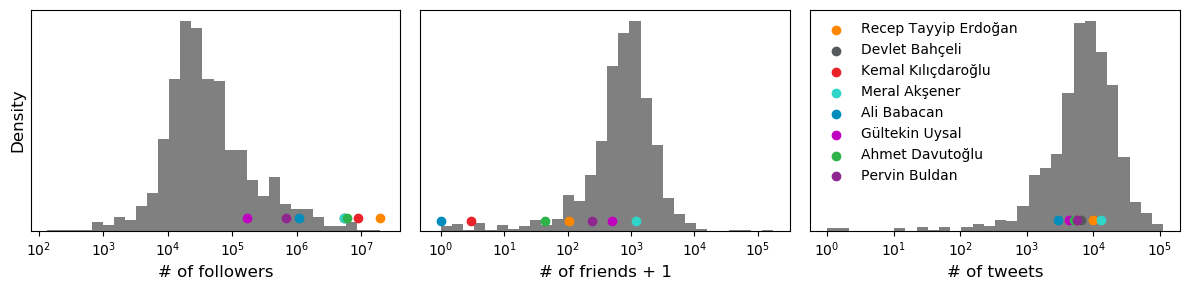

In [11]:
fig = plt.figure(figsize=(12,3), tight_layout=True)
gs = gridspec.GridSpec(1, 3)

axFl = fig.add_subplot(gs[0, 0])
axFr = fig.add_subplot(gs[0, 1])
axTw = fig.add_subplot(gs[0, 2])

frCount, flCount, twCount = list(), list(), list()
for udata in profileStats.values():
    dates = sorted(udata['stats'])
    frCount.append(udata['stats'][dates[-1]]['friends'])
    flCount.append(udata['stats'][dates[-1]]['followers'])
    twCount.append(udata['stats'][dates[-1]]['tweets'])

axFl.hist(np.log10(np.array(flCount)), bins=30, fc='0.5', density=True)
axFl.set_xlabel('# of followers', fontsize=12)
axFl.set_yticks([])
axFl.set_xticks(range(2,8))
axFl.set_xticklabels([r'$10^{{{}}}$'.format(x) for x in range(2,8)])

axFr.hist(np.log10(np.array(frCount)+1), bins=30, fc='0.5', density=True)
axFr.set_xlabel('# of friends + 1', fontsize=12)
axFr.set_yticks([])
axFr.set_xticks(range(6))
axFr.set_xticklabels([r'$10^{{{}}}$'.format(x) for x in range(6)])

axTw.hist(np.log10(np.array(twCount)), bins=30, fc='0.5', density=True)
axTw.set_xlabel('# of tweets', fontsize=12)
axTw.set_yticks([])
axTw.set_xticks(range(6))
axTw.set_xticklabels([r'$10^{{{}}}$'.format(x) for x in range(6)])

for uid in LEADER_INFO:
    axFr.scatter([np.log10(profileStats[uid]['stats'][dates[-1]]['friends'])], [0.05],
                 c=LEADER_INFO[uid]['color'], zorder=9)
    axFl.scatter([np.log10(profileStats[uid]['stats'][dates[-1]]['followers'])], [0.05],
                 c=LEADER_INFO[uid]['color'], zorder=9)
    axTw.scatter([np.log10(profileStats[uid]['stats'][dates[-1]]['tweets'])], [0.05],
                 c=LEADER_INFO[uid]['color'], zorder=9, label=LEADER_INFO[uid]['name'])
axTw.legend(frameon=False)
axFl.set_ylabel('Density', fontsize=12)
plt.tight_layout()
plt.savefig('figures/politician_profiles.pdf', dpi=300, transparent=True, bbox_inches='tight')


/tmp/ipykernel_178115/1447051789.py:5: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  axarr[i].stem([parser.parse(d) for d in dates[:-1]],


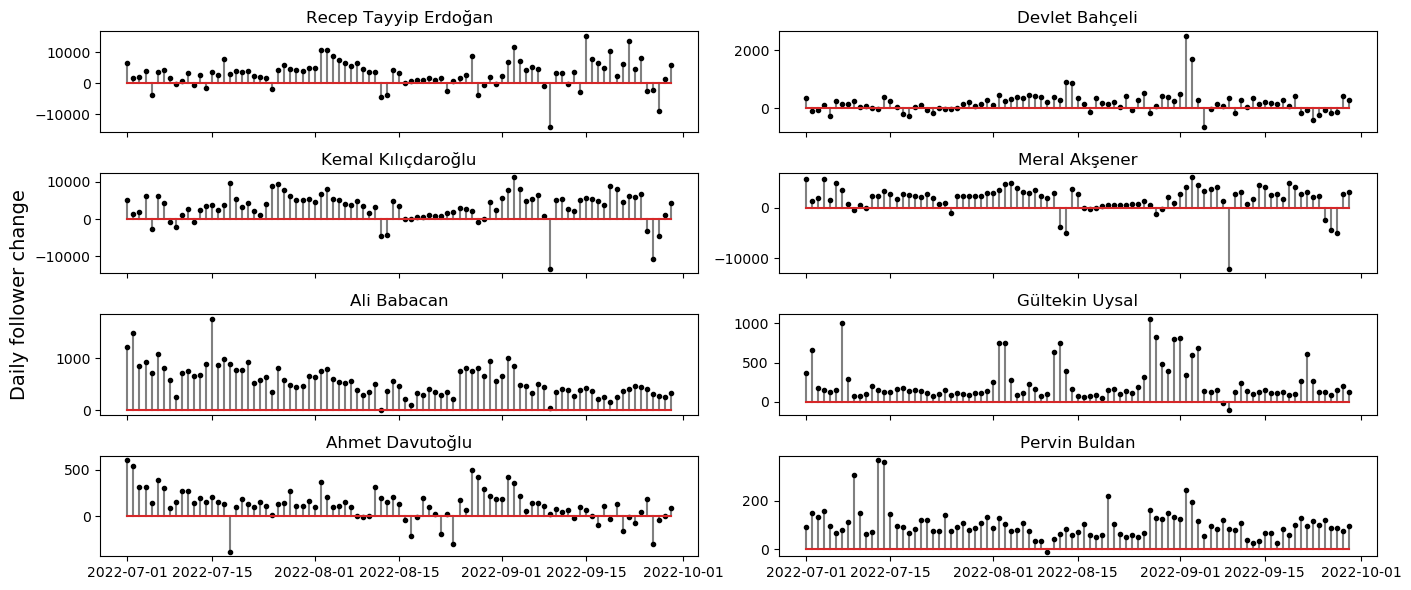

In [10]:
fig, axarr = plt.subplots(4,2, figsize=(14,6), sharex=True)
axarr = axarr.flatten()
for i,uid in enumerate(LEADER_INFO):
    dates = sorted(profileStats[uid]['stats'].keys())
    axarr[i].stem([parser.parse(d) for d in dates[:-1]],
                  [profileStats[uid]['stats'][dates[i+1]]['followers']-profileStats[uid]['stats'][dates[i]]['followers'] 
                        for i in range(len(dates)-1)],
                 linefmt='grey', markerfmt='k.')
    axarr[i].set_title(LEADER_INFO[uid]['name'])
fig.text(0, 0.5, 'Daily follower change', ha='center', va='center', rotation='vertical', fontsize=14)
plt.tight_layout()
plt.savefig('figures/politician_followerchange.pdf', dpi=300, transparent=True, bbox_inches='tight')

### FOLLOWER PROFILE STATS

In [4]:
followerProfiles = dict()
for fname in glob.glob('../dataset/networks/nodes/2022-09/account_*.jsons.gz'):
    print(fname)
    with gzip.open(fname, 'r') as fl:
        for line in fl:
            temp = json.loads(line)
            
            followerProfiles[temp['id']] = {
                'followers': temp['followers'],
                'friends': temp['friends'],
                'tweets': temp['tweets'],
                'age': (parser.parse('2022-10-01').astimezone(tz=None) - parser.parse(temp['created_at'])).days
            }
            
dfFollowers = pd.DataFrame.from_dict(followerProfiles, orient='index')
del followerProfiles
dfFollowers

../dataset/networks/nodes/2022-09/account_statistics_23.jsons.gz
../dataset/networks/nodes/2022-09/account_statistics_33.jsons.gz
../dataset/networks/nodes/2022-09/account_statistics_13.jsons.gz
../dataset/networks/nodes/2022-09/account_statistics_4.jsons.gz
../dataset/networks/nodes/2022-09/account_statistics_34.jsons.gz
../dataset/networks/nodes/2022-09/account_statistics_24.jsons.gz
../dataset/networks/nodes/2022-09/account_statistics_14.jsons.gz
../dataset/networks/nodes/2022-09/account_statistics_3.jsons.gz
../dataset/networks/nodes/2022-09/account_statistics_5.jsons.gz
../dataset/networks/nodes/2022-09/account_statistics_12.jsons.gz
../dataset/networks/nodes/2022-09/account_statistics_22.jsons.gz
../dataset/networks/nodes/2022-09/account_statistics_32.jsons.gz
../dataset/networks/nodes/2022-09/account_statistics_2.jsons.gz
../dataset/networks/nodes/2022-09/account_statistics_15.jsons.gz
../dataset/networks/nodes/2022-09/account_statistics_35.jsons.gz
../dataset/networks/nodes/202

,followers,friends,tweets,age
1454755810303692800,5,39,184,334
1497865508703592448,6,88,0,215
2257904018,293,359,24419,3204
1449464451325997059,0,3,0,349
1308687568016375808,44,60,20,737
...,...,...,...,...
1090927480309977089,257,380,5987,1338
1103201695033708544,0,3,7,1304
1103586676935458816,3,81,0,1303
575264186,137,356,192,3796


In [51]:
'''
sys.path.insert(0,'..')
from preprocessing import config as cf

botScores = dict()
with gzip.open('{}/twitter_networks/botscores_2022-09.tsv.gz'.format(cf.ELECTION_DATA_PATH), 'r') as fl:
    for i,line in enumerate(fl):
        temp = line.split()
        botScores[int(temp[0])] = float(temp[1])
'''

dfFollowers["userid"] = dfFollowers.index.astype(int)
dfFollowers["botscore"] = dfFollowers["userid"].map(botScores)
dfFollowers = dfFollowers[dfFollowers['age'] < 5000]
dfFollowers

,followers,friends,tweets,age,botscore,userid
1454755810303692800,5,39,184,334,0.34,1454755810303692800
1497865508703592448,6,88,0,215,0.62,1497865508703592448
2257904018,293,359,24419,3204,0.01,2257904018
1449464451325997059,0,3,0,349,0.68,1449464451325997059
1308687568016375808,44,60,20,737,0.16,1308687568016375808
...,...,...,...,...,...,...
1090927480309977089,257,380,5987,1338,0.06,1090927480309977089
1103201695033708544,0,3,7,1304,0.52,1103201695033708544
1103586676935458816,3,81,0,1303,0.64,1103586676935458816
575264186,137,356,192,3796,0.19,575264186


/cta/users/ovarol/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3202: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1426: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


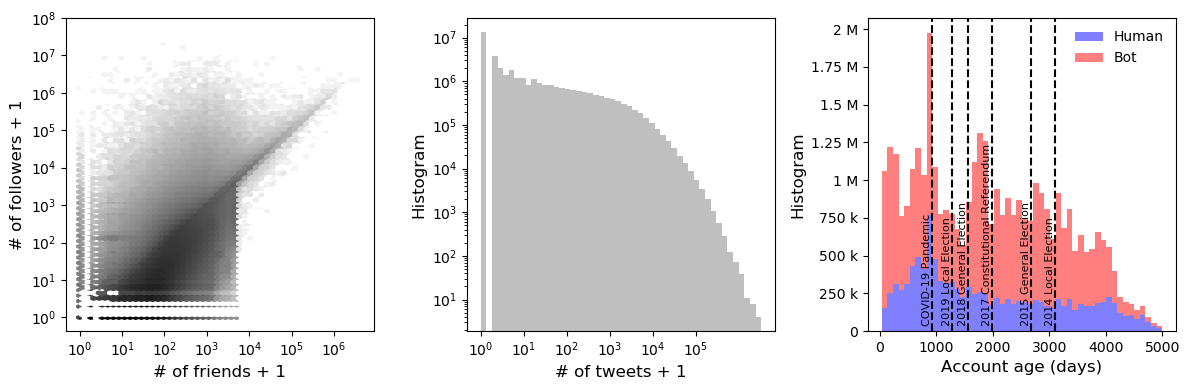

In [59]:
# Friend-follower heatmap
# Number of tweets
# Account age

fig = plt.figure(figsize=(12,4), tight_layout=True)
gs = gridspec.GridSpec(1, 3)

axFl = fig.add_subplot(gs[0, 0])
axTw = fig.add_subplot(gs[0, 1])
axAge = fig.add_subplot(gs[0, 2])

axFl.hexbin(np.log10(dfFollowers['friends']+1), np.log10(dfFollowers['followers']+1), 
            gridsize=(50,50), bins='log', cmap='binary')
axFl.set_xlabel('# of friends + 1', fontsize=12)
axFl.set_ylabel('# of followers + 1', fontsize=12)
axFl.set_xticks(range(7))
axFl.set_xticklabels([r'$10^{{{}}}$'.format(x) for x in range(7)])
axFl.set_yticks(range(9))
axFl.set_yticklabels([r'$10^{{{}}}$'.format(x) for x in range(9)])

axTw.hist(np.log10(dfFollowers['tweets']+1), bins=50, fc='0.5', alpha=0.5)
axTw.set_yscale('log')
axTw.set_xlabel('# of tweets + 1', fontsize=12)
axTw.set_ylabel('Histogram', fontsize=12)
axTw.set_xticks(range(6))
axTw.set_xticklabels([r'$10^{{{}}}$'.format(x) for x in range(6)])

axAge.hist([dfFollowers[dfFollowers["botscore"] < 0.5]['age'], 
            dfFollowers[dfFollowers["botscore"] >= 0.5]['age']], 
            stacked=True, bins=50, color=['b','r'], label=['Human', 'Bot'], alpha=0.5)
axAge.legend(frameon=False)
#axAge.set_yscale('log')
axAge.set_xlabel('Account age (days)', fontsize=12)
axAge.set_ylabel('Histogram', fontsize=12)
axAge.yaxis.set_major_formatter(ticker.EngFormatter())

elections = {
    "COVID-19 Pandemic": "2020-03-11",
    "2019 Local Election": "2019-03-31",
    "2018 General Election": "2018-06-24",
    "2017 Constitutional Referendum": "2017-04-16",
    "2015 General Election": "2015-06-07",
    "2014 Local Election": "2014-03-30",
    #"2011 General Election": "2011-06-12",
}

for k,v in elections.items():
    ddiff = (parser.parse('2022-10-01') - parser.parse(v)).days
    axAge.axvline(ddiff, linestyle='--', c='k')
    axAge.text(ddiff, 50000, k, rotation=90, c='k', fontsize=8, ha='right')

plt.tight_layout()
plt.savefig('figures/follower_profile_stats.pdf', dpi=300, transparent=True, bbox_inches='tight')


# Politician per follower


In [23]:
(parser.parse('2022-10-01') - parser.parse('2019-06-30')).days

1189

# Politician shared account network